In [1]:
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
import zipfile
import io
from PIL import Image
import os
import csv
import torch.optim as optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_names = pd.read_csv("/content/drive/MyDrive/embed_list_names.csv", sep=',', header=None)
df_np = np.genfromtxt("/content/drive/MyDrive/embed_list_np.csv", delimiter=',')

In [4]:
class DeepArchitecture(nn.Module):
    def __init__(self, embed_size):
        super(DeepArchitecture, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(3, 32, 5), nn.ReLU(),  # in_channels, out_channels, kernel_size,  kernel size, stride, num kernels
                                     nn.MaxPool2d(2),
                                     nn.Conv2d(32, 64, 5), nn.ReLU(),
                                     nn.MaxPool2d(2),
                                     nn.Conv2d(64, 128, 5), nn.ReLU(),
                                     nn.MaxPool2d(2),
                                     nn.Conv2d(128, 256, 5), nn.ReLU(),
                                     nn.MaxPool2d(2))

        self.fc = nn.Sequential(nn.Linear(256*121, 2*embed_size),
                                nn.ReLU(),
                                nn.Linear(2*embed_size, 2*embed_size),
                                nn.ReLU(),
                                nn.Linear(2*embed_size, embed_size))

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output


class FaceNet(nn.Module):
    def __init__(self, embed_size, is_train):
        super(FaceNet, self).__init__()
        self.deep_arch = DeepArchitecture(embed_size=embed_size)
        self.is_train = is_train

    def l2_norm(self, input):
        input_size = input.size()
        buffer = torch.pow(input, 2)
        normp = torch.sum(buffer, 1).add_(1e-10)
        norm = torch.sqrt(normp)
        _output = torch.div(input, norm.view(-1, 1).expand_as(input))
        output = _output.view(input_size)
        return output


    def forward(self, x1, x2, x3):
        if self.is_train:
          output1 = self.deep_arch(x1)
          output2 = self.deep_arch(x2)
          output3 = self.deep_arch(x3)
          output1 = self.l2_norm(output1)
          output2 = self.l2_norm(output2)
          output3 = self.l2_norm(output3)
          return output1, output2, output3
        else:
          output1 = self.deep_arch(x1)
          output1 = self.l2_norm(output1)
          return output1

In [5]:
model = FaceNet(embed_size=128, is_train=True)
if torch.cuda.is_available():
    model.cuda()
model.load_state_dict(torch.load("/content/drive/MyDrive/chckpnt10_embed128_allData_model.pth"))
lr = 1e-3
wd = 1e-5
optimizer = optim.Adam(params=model.parameters(), lr=lr, weight_decay=wd)

In [6]:
archive15 = zipfile.ZipFile('/content/drive/MyDrive/test_set15.zip', 'r')
archive15.extractall()
archive = zipfile.ZipFile('/content/drive/MyDrive/train_set.zip', 'r')
archive.extractall()

Hamid_Karzai & Hamid_Karzai
Diff_first: 0.12
Diff_second: 0.01 /content/train_set/Hamid_Karzai/Hamid_Karzai_0022.jpg 0.013383706100285053


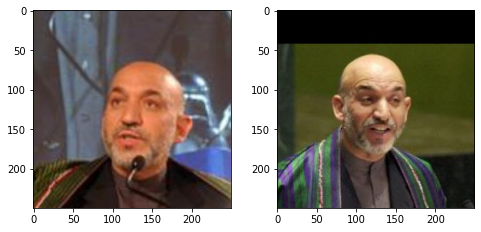

In [11]:
fig = plt.figure(figsize=(8, 8))
file_path = '/content/test_set15'
model.eval()

with torch.no_grad():

    euc_dist = 0
    index = 12
    imgFile1 = file_path + '/' + os.listdir(file_path)[index] + '/' + os.listdir(file_path)[index] + '_0015.jpg'

    imgFile2 = file_path + '/' + os.listdir(file_path)[index] + '/' + os.listdir(file_path)[index] + '_0003.jpg'
    img1, label1 = np.array(Image.open(imgFile1), dtype='float32'), os.listdir(file_path)[index]
    label1 = os.listdir(file_path)[index]
    img2 = np.array(Image.open(imgFile2), dtype='float32')


    img1 = np.transpose(img1, (2, 0, 1))
    img2 = np.transpose(img2, (2, 0, 1))

    
    inputs = (img1, img2, img2)
    if torch.cuda.is_available():
      inputs = list(torch.tensor(inps).to('cuda', dtype=torch.float) for inps in inputs)
    optimizer.zero_grad()
    embed1, embed2, embed3 = model(torch.unsqueeze(inputs[0], axis=0), torch.unsqueeze(inputs[1], axis=0), torch.unsqueeze(inputs[2], axis=0))
    euclidean_distance = F.pairwise_distance(embed1, embed2)
    min_dist = euclidean_distance
    best_min_dist = euclidean_distance
    label_min = label1
    best_correct_label = 0.
    for idx in range(len(df_np)):
        euc_dist = F.pairwise_distance(embed1, torch.tensor(df_np[idx]).to('cuda', dtype=torch.float))
        if euc_dist < best_min_dist and df_names[idx][0] == label1 and euc_dist > 0.01:
            best_min_dist = euc_dist
            best_correct_label = euc_dist
        if euc_dist < min_dist and df_names[idx][0] != label1:
            euc_dist += 0.03
        if euc_dist < min_dist and euc_dist > 0.01:
            min_dist = euc_dist
            label_min, img_name = df_names[idx][0], df_names[idx][1]
    name1, name2 = label1, label_min
    text = f"{name1} & {name2}\nDiff_first: {euclidean_distance.item():.2f}\nDiff_second: {min_dist.item():.2f}"
    imgFile4 = '/content/train_set' + '/' + name2 + '/' + name2 + '_0001.jpg'
    img4 = np.array(Image.open(imgFile4), dtype='float32')
    print(text, img_name, best_correct_label.item())
    fig.add_subplot(2,2,1)
    plt.imshow(Image.fromarray( np.asarray( np.clip(np.array(torch.permute(inputs[0], (1, 2, 0)).cpu()),0,255), dtype="uint8"), "RGB" ))
    fig.add_subplot(2,2,2)
    plt.imshow(Image.fromarray( np.asarray( np.clip(img4,0,255), dtype="uint8"), "RGB" ))
plt.show()